# Data Processing and Analysis
In this notebook, I will be preprocessing data obtain from https://www.ebi.ac.uk/gwas/efotraits/EFO_0000685 and simulating data that can be used to train our machine learning models for Arthritis prediction. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocess data from https://www.ebi.ac.uk/gwas/efotraits/EFO_0000685

In [2]:
# load datasets
df = pd.read_csv('data/efotraits_EFO_0000685-associations-2021-06-17.csv')

# process dataset 
cols_to_keep = ['Variant and risk allele', 'RAF', 'Beta']
df = df.drop(df.columns.difference(cols_to_keep), axis=1)
df = df.replace('NR',np.nan)
df = df.replace("'-",np.nan)
df = df.dropna()

df = df.rename(columns = {'Variant and risk allele':'id','RAF':'raf', 'Beta':'beta'})

df['id'] = df['id'].str.split("-", 1, expand=True)
df['beta'] = df['beta'].str.split(" ", 1, expand=True)

df['raf'] = df['raf'].astype(float)
df['beta'] = df['beta'].astype(float)

# save dataframe to csv
df.to_csv('data/EFO_0000685.csv')

## Simulate data- unbiased
I will use the GWAS in EFO_0000685.csv to simulate individual SNP data with associated arthritis label. I will use the GWAS to determine relevant SNPs to arthritis and spread them across a population based on their minor allele frequencies. I will simulate 10,000 individuals.

# Simulate data- biased
I want to create a simulated dataset with low risk, medium risk, and high risk individuals, so I will change to probabilities of having some SNPS higher. This method will create a better dataset because it is more realistic. 

In [3]:
df = pd.read_csv('data/EFO_0000685.csv')
cols_to_keep = ['id', 'raf', 'beta']
df = df.drop(df.columns.difference(cols_to_keep), axis=1)
df = df.drop_duplicates(subset=['id'])

In [4]:
# risk labels, 0=low, 1=medium, 2=high
risk_labels = [0, 1, 2]

# proportion/probability of each risk (the lower the risk the more common)
risk_prob = [0.5, 0.35, 0.15]

# varying probabilities of having SNPs
low_risk_bias = np.arange(0.1, 0.5, 0.05)
medium_risk_bias = np.arange(0.5, 0.75, 0.05)
high_risk_bias = np.arange(0.75, 1, 0.05)
risk_bias = [low_risk_bias, medium_risk_bias, high_risk_bias]

In [5]:
# simulate 10,000 individuals
individuals = []
labels = []
for _ in range(10000):
    label = np.random.choice(a=risk_labels, p=risk_prob)
    bias = np.random.choice(risk_bias[label])
    snps = (df['raf'].apply(lambda x: np.random.choice(a=[0,1], p=[1-(x*bias), x*bias])))
    individuals.append(snps.values)  
    labels.append(label)

In [6]:
simulated_df = pd.DataFrame(individuals, columns=df['id'])
simulated_df.columns.name = 'n'

In [7]:
# add polygenic risk score for each individual
beta_dict = df.set_index('id')['beta'].to_dict()
beta_values = np.array([beta_dict.get(x) for x in simulated_df.columns])
prs = simulated_df.apply(lambda x: (x*beta_values).sum(), axis=1)
simulated_df['prs'] = prs
simulated_df['label'] = labels

In [8]:
simulated_df
simulated_df.groupby('label')['prs'].mean()

label
0     9.513040
1    21.035957
2    30.011589
Name: prs, dtype: float64

Text(0, 0.5, 'Frequency')

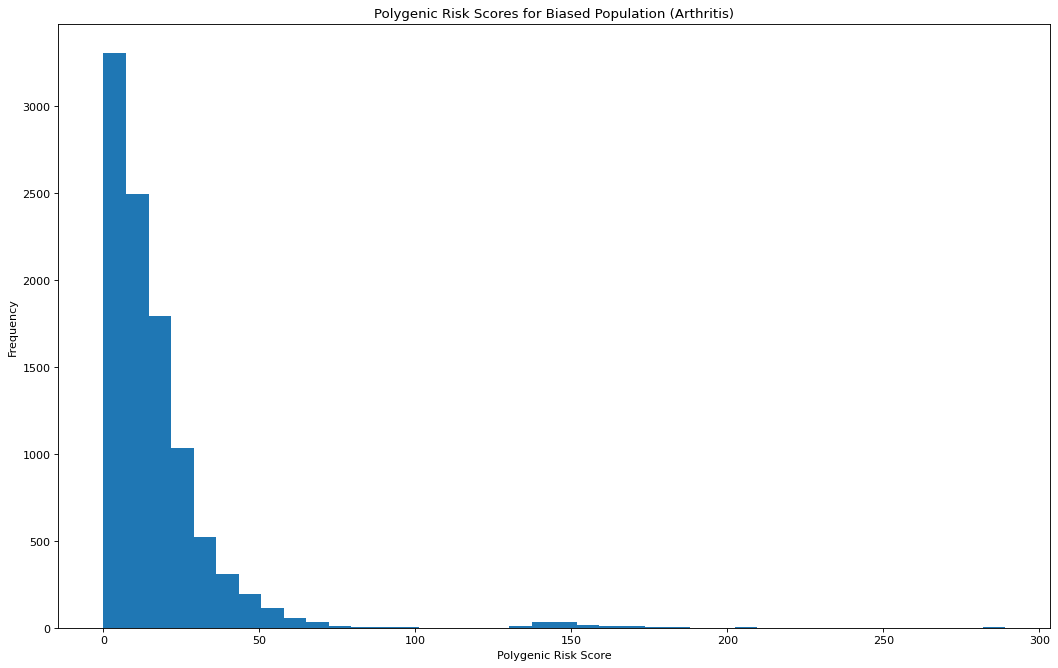

In [9]:
plt.figure(figsize=(16, 10), dpi=80)
plt.hist(simulated_df['prs'], 40)
plt.title('Polygenic Risk Scores for Biased Population (Arthritis)')
plt.xlabel('Polygenic Risk Score')
plt.ylabel('Frequency')

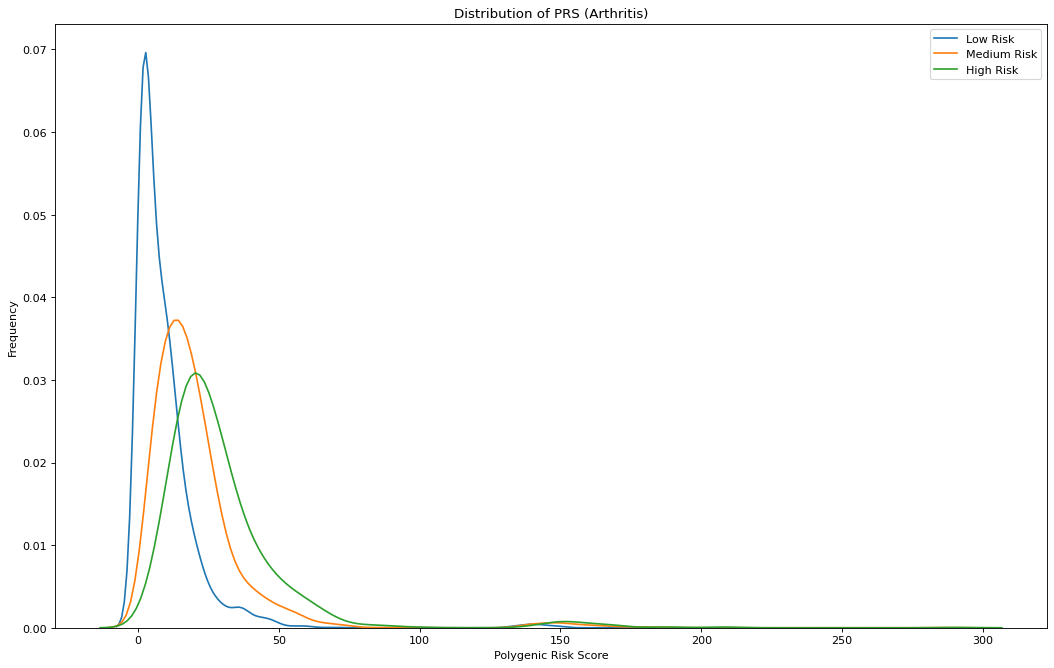

In [10]:
# check distribution of prs
plt.figure(figsize=(16, 10), dpi=80)
sns.kdeplot(simulated_df[simulated_df['label'] == 0]['prs'], label="Low Risk")
sns.kdeplot(simulated_df[simulated_df['label'] == 1]['prs'], label="Medium Risk")
sns.kdeplot(simulated_df[simulated_df['label'] == 2]['prs'], label="High Risk")
plt.title('Distribution of PRS (Arthritis)')
plt.xlabel('Polygenic Risk Score')
plt.ylabel('Frequency')
plt.legend()

In [11]:
simulated_df.to_csv('simulated_data.csv')

In [12]:
simulated_df

n,rs2476601,rs2451258,rs147622113,rs59716545,rs947474,rs3824660,rs8026898,rs2301888,rs8133843,rs13330176,...,rs1679568,rs284511,rs923880,rs41005,rs13015080,rs1079467,rs16973500,rs1498103,prs,label
0,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,7.52739,0
1,0,0,0,1,1,0,1,0,1,0,...,0,1,0,1,0,0,0,0,3.49189,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.99875,0
3,1,1,0,0,0,1,1,1,1,0,...,0,0,0,0,0,1,0,0,20.20512,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,5.89957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,0,0,1,1,0,0,1,0,...,0,0,1,0,1,0,0,1,29.74868,2
9996,0,1,0,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,9.48961,2
9997,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,9.83887,2
9998,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,66.68887,1
